# Extract tiles of fixed area 

First tries with GMRT Service export function, to auto extract a lot of imagedata via API and script.

**Obsolate:** Later not uses to generate final dataset.

In [1]:
import os
import requests
import time
import math

# Parameters
start_lat = 30  # Starting latitude
start_lon = -60  # Starting longitude
num_tiles = 10  # Number of tiles in each direction
tile_width_deg = 1  # Width of each tile in degrees (longitude)
tile_pixels = 800  # Pixel width/height of each tile
output_folder = "equal_tiles_highres"

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Base URL for the ImageServer
base_url = "https://www.gmrt.org/services/ImageServer"

# Function to calculate the height in degrees for Mercator projection
def calculate_lat_height(center_lat, pixel_height, pixel_width):
    lat_rad = math.radians(center_lat)
    degrees_per_pixel = math.cos(lat_rad)
    return (pixel_height / pixel_width) * degrees_per_pixel

# Store grid data for visualization
grid_data = []

# Start downloading tiles
current_lat = start_lat
for i in range(num_tiles):  # Loop for latitude tiles
    current_lon = start_lon
    for j in range(num_tiles):  # Loop for longitude tiles
        # Calculate tile bounds
        tile_height_deg = calculate_lat_height(current_lat, tile_pixels, tile_pixels)
        minlatitude = current_lat
        maxlatitude = current_lat + tile_height_deg
        minlongitude = current_lon
        maxlongitude = current_lon + tile_width_deg

        # Store grid information for visualization
        grid_data.append((minlatitude, maxlatitude, minlongitude, maxlongitude))

        # Construct the URL
        params = {
            "minlatitude": minlatitude,
            "maxlatitude": maxlatitude,
            "minlongitude": minlongitude,
            "maxlongitude": maxlongitude,
            "width": tile_pixels,
            "mask": "true",
            "download": "true",
        }

        # Format the file name
        tile_name = (
            f"tile_{minlatitude:.1f}_{maxlatitude:.1f}_"
            f"{minlongitude:.1f}_{maxlongitude:.1f}.png"
        )

        # Download the tile
        try:
            print(f"Downloading tile: {tile_name}")
            response = requests.get(base_url, params=params)

            if response.status_code == 200:
                # Save the image
                with open(os.path.join(output_folder, tile_name), "wb") as file:
                    file.write(response.content)
            else:
                print(f"Failed to download tile: {tile_name} - HTTP {response.status_code}")
        except Exception as e:
            print(f"Error downloading tile {tile_name}: {e}")

        # Move to the next tile (longitude)
        current_lon += tile_width_deg

        # Respectful delay between requests
        time.sleep(1)

    # Move to the next tile row (latitude)
    current_lat += tile_height_deg

print("Download complete.")


Download complete.


/home/codespace/.python/current/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/codespace/.python/current/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


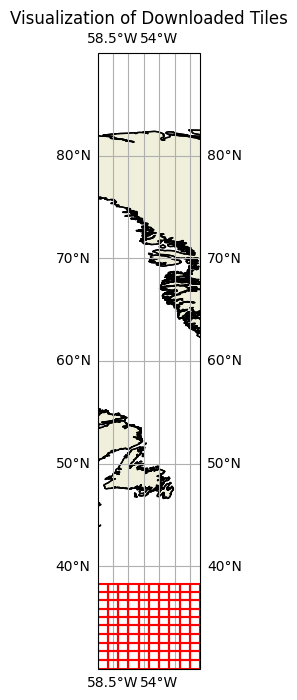

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define grid data
# grid_data = [(minlatitude, maxlatitude, minlongitude, maxlongitude), ...]

# Set up the map
fig, ax = plt.subplots(
    figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()}
)

# Add map features
ax.set_extent([start_lon, start_lon + num_tiles * tile_width_deg,
               start_lat, start_lat + num_tiles * calculate_lat_height(start_lat, tile_pixels, tile_pixels) * num_tiles], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True)

# Plot the grid
for minlat, maxlat, minlon, maxlon in grid_data:
    # Draw rectangle for each tile
    ax.plot(
        [minlon, maxlon, maxlon, minlon, minlon],
        [minlat, minlat, maxlat, maxlat, minlat],
        color="red",
        transform=ccrs.PlateCarree(),
    )

# Show the map
plt.title("Visualization of Downloaded Tiles")
plt.show()
